<a href="https://colab.research.google.com/github/gyana-ranjan-dash/World_proverty_analysis/blob/main/World_poverty_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
pip install geopandas


In [31]:
pip install geoplot


In [32]:
pip install pygal_maps_world


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
from shapely.geometry import polygon,point
from plotnine import *
from shapely.geometry import Point 
import geopandas as gpd
import geoplot
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling as profile
import plotly.express as px
import ipywidgets
from ipywidgets import interact
from ipywidgets import interact_manual

In [34]:
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [35]:
# importing data from CSV file

country_df = pd.read_csv("https://raw.githubusercontent.com/gyana-ranjan-dash/World_proverty_analysis/main/Country-data.csv")

In [36]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [37]:
country_df.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


In [38]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [39]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [40]:
country_df.sort_values(by='health', ascending = False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
159,United States,7.3,12.400,17.90,15.8000,49400,1.220,78.7,1.93,48400
101,"Micronesia, Fed. Sts.",40.0,23.500,14.20,81.0000,3340,3.800,65.4,3.46,2860
132,Sierra Leone,160.0,16.800,13.10,34.5000,1220,17.200,55.0,5.20,399
110,Netherlands,4.5,72.000,11.90,63.6000,45500,0.848,80.7,1.79,50300
54,France,4.2,26.800,11.90,28.1000,36900,1.050,81.4,2.03,40600
...,...,...,...,...,...,...,...,...,...,...
154,Turkmenistan,62.0,76.300,2.50,44.5000,9940,2.310,67.9,2.83,4440
38,"Congo, Rep.",63.9,85.100,2.46,54.7000,5190,20.700,60.4,4.95,2740
116,Pakistan,92.1,13.500,2.20,19.4000,4280,10.900,65.3,3.85,1040
107,Myanmar,64.4,0.109,1.97,0.0659,3720,7.040,66.8,2.41,988


In [41]:
country_df.sort_values(by='child_mort', ascending = False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
66,Haiti,208.0,15.3,6.91,64.7,1500,5.450,32.1,3.33,662
132,Sierra Leone,160.0,16.8,13.10,34.5,1220,17.200,55.0,5.20,399
32,Chad,150.0,36.8,4.53,43.5,1930,6.390,56.5,6.59,897
31,Central African Republic,149.0,11.8,3.98,26.5,888,2.010,47.5,5.21,446
97,Mali,137.0,22.8,4.98,35.1,1870,4.370,59.5,6.55,708
...,...,...,...,...,...,...,...,...,...,...
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200
144,Sweden,3.0,46.2,9.63,40.7,42900,0.991,81.5,1.98,52100
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000


In [42]:
country_df.isnull().mean()*100

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [43]:
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100

In [44]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [45]:
df = country_df[["country","child_mort","income","gdpp"]]
df.head()


,country,child_mort,income,gdpp
0,Afghanistan,90.2,1610,553
1,Albania,16.6,9930,4090
2,Algeria,27.3,12900,4460
3,Angola,119.0,5900,3530
4,Antigua and Barbuda,10.3,19100,12200


In [46]:
df.columns

Index(['country', 'child_mort', 'income', 'gdpp'], dtype='object')

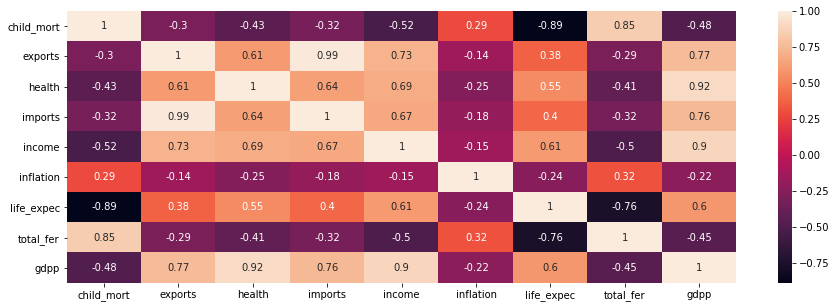

In [52]:
plt.figure(figsize=(15,5))
sns.heatmap(country_df.corr(), annot= True)
plt.show()

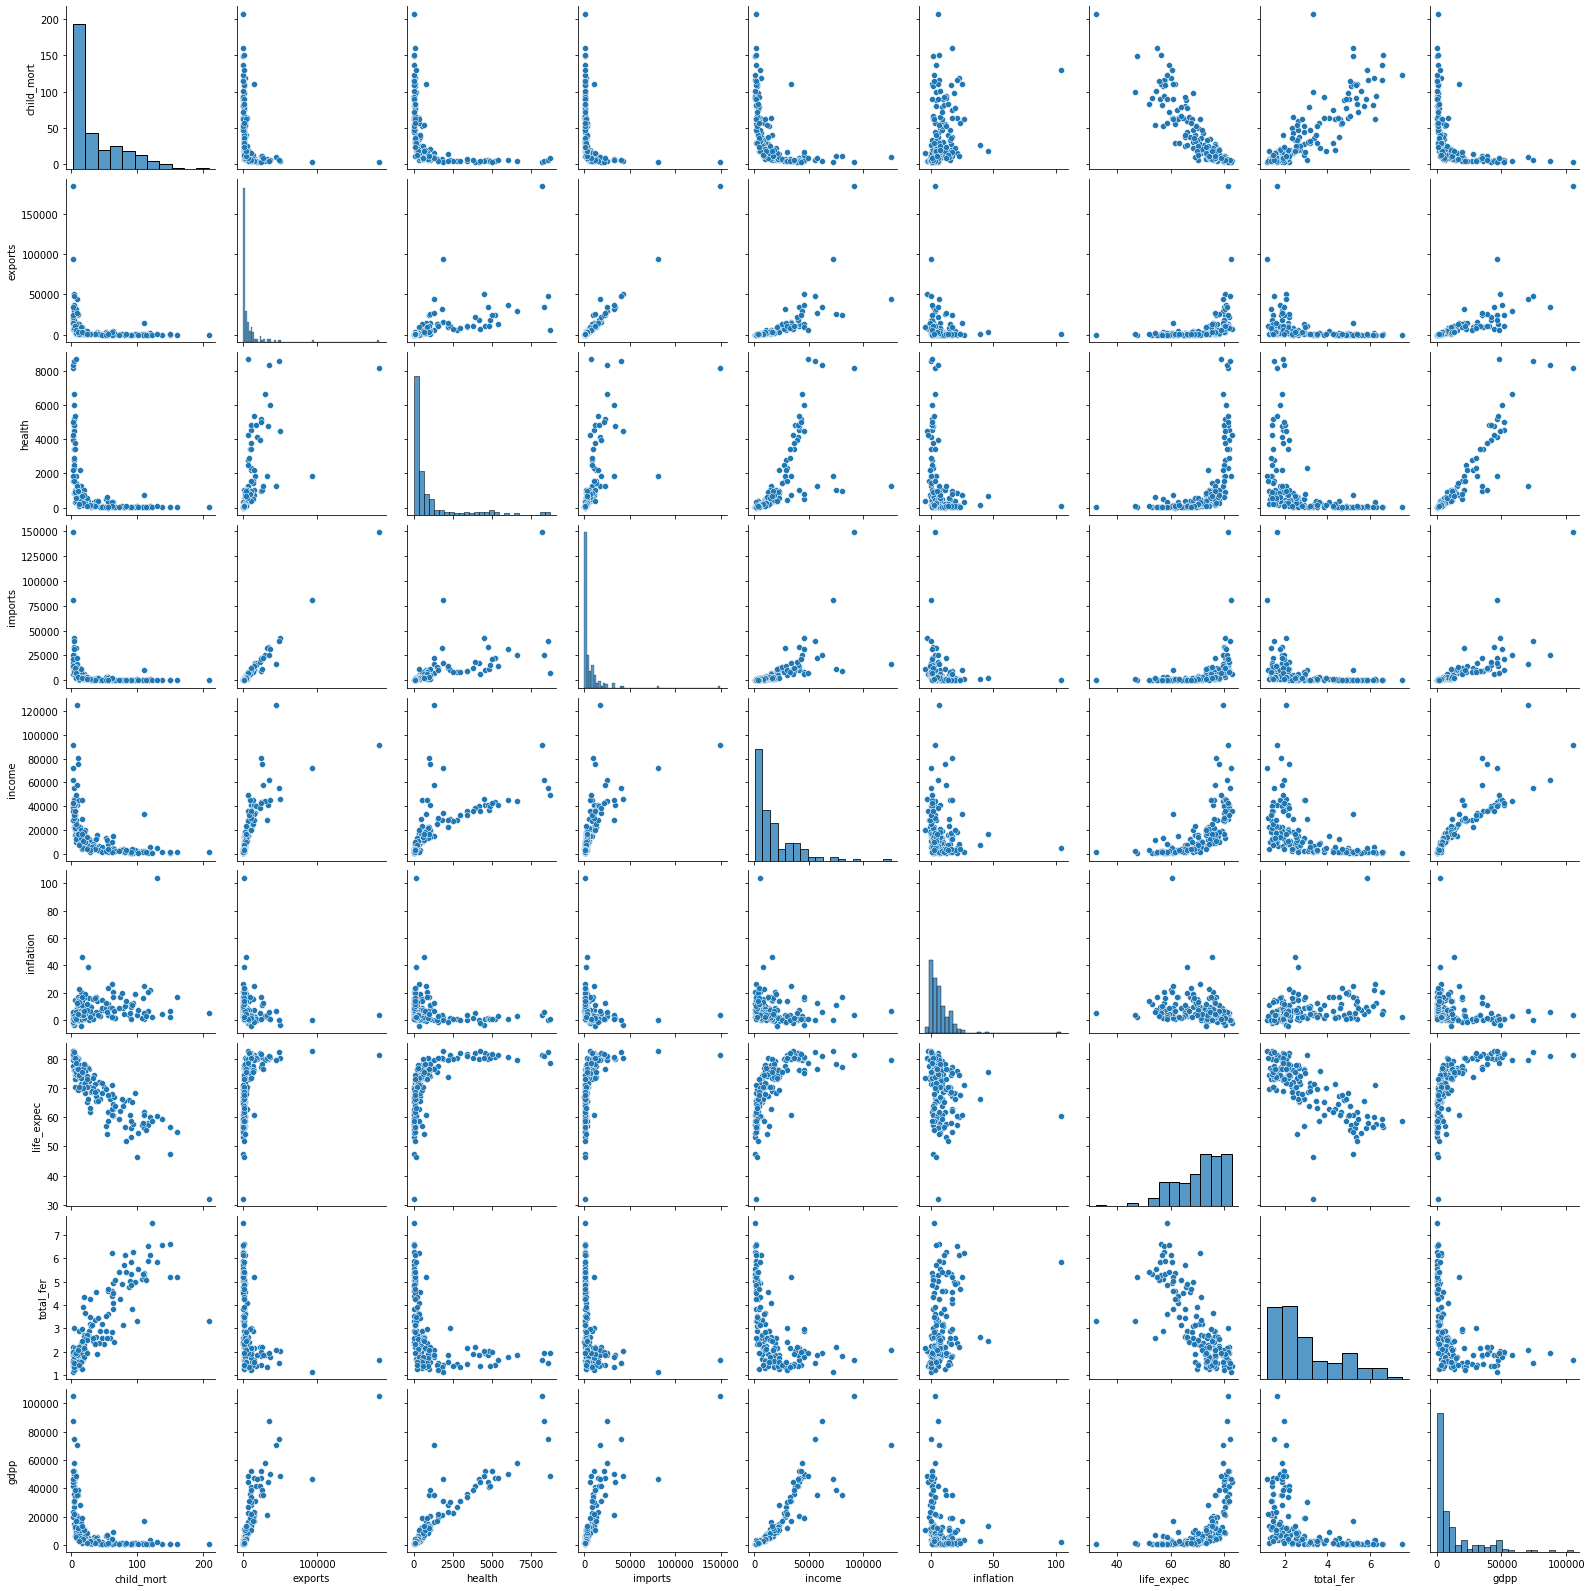

In [53]:
sns.pairplot(country_df)

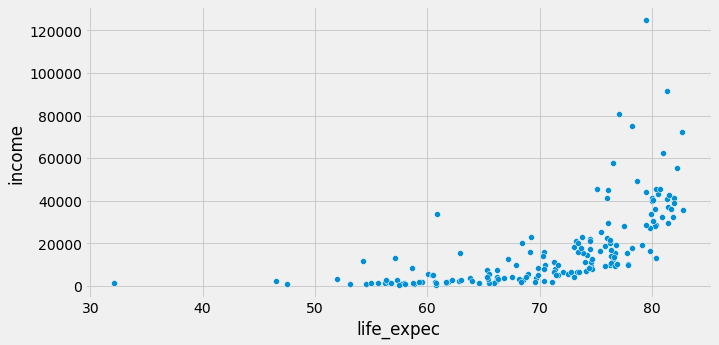

In [68]:
plt.figure(figsize= (10,5))
sns.scatterplot(y= 'income', x ='life_expec' ,data= country_df)

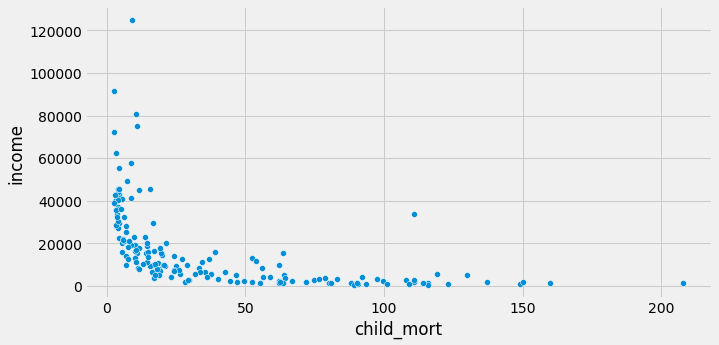

In [69]:
plt.figure(figsize= (10,5))
sns.scatterplot(y= 'income', x ='child_mort' ,data= country_df)